# FFT Analysis

This notebook is meant for analysing `.wav` samples with Python. Python is easier to work with than C++, and enables quicker prototyping.

In [1]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.fft import fft, irfft, irfft2 ,rfft, rfft2, rfftfreq
from scipy.io import wavfile

## Analysis

This section allows us to check and analyse our sample audio files.

In [2]:
# plot amplitude against time and amplitude against frequency graphs
def preview(filename, bits_per_sample=8):
    sample_rate, data = wavfile.read(filename)
    num_samples = len(data)
    num_channels = 1 if len(data.shape) == 1 else data.shape[1]
    duration = num_samples / sample_rate

    x1 = np.linspace(0, duration, num_samples, endpoint=False)
    # normalize values
    y1 = (data / 255 * 2 - 1) if bits_per_sample == 8 else data / 32768

    x2 = rfftfreq(num_samples, 1 / sample_rate)
    y2 = rfft2(y1) if num_channels == 2 else rfft(y1)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.title("Amplitude against Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized amplitude")
    plt.axhline(0, linestyle='--').set_color('black')
    plt.plot(x1[:1000], y1[:1000])

    plt.subplot(1, 2, 2)
    plt.title("Amplitude against Frequency")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Normalized amplitude")
    plt.plot(x2[:1000], np.abs(y2[:1000]))

    plt.show()

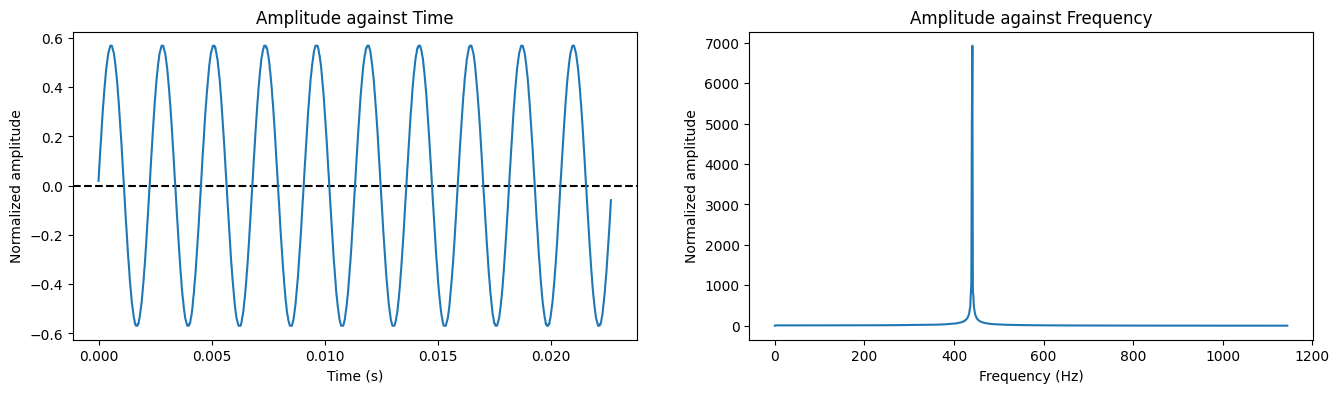

In [3]:
preview("samples/8-bit.wav")

C:\Users\lesli\AppData\Local\Temp\ipykernel_40872\500776641.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(filename)


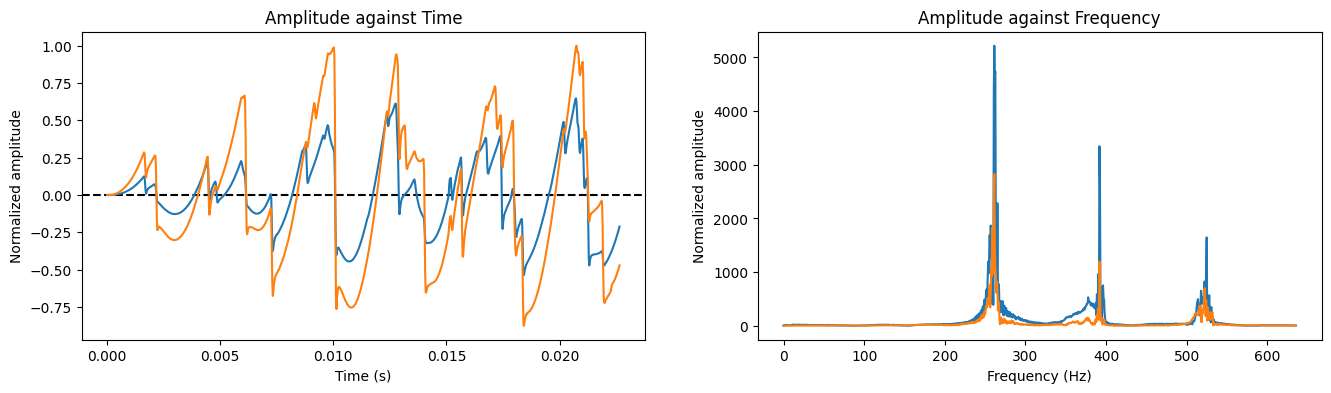

In [4]:
preview("samples/16-bit.wav", bits_per_sample=16)

## Prototype

The following section is for experimenting with the `scipy.fft` module. Since `fft`, `ifft`, `rfft` etc are already implemented, we can apply transformations to test out strategies to shift pitches in audio without worrying about the correctness of our FFT routines.

In [5]:
def shift(filename, output, shift, bits_per_sample=8):
    sample_rate, data = wavfile.read(filename)
    num_samples = len(data)
    num_channels = 1 if len(data.shape) == 1 else data.shape[1]
    duration = num_samples / sample_rate

    # normalize values
    y1 = (data / 255 * 2 - 1) if bits_per_sample == 8 else data / 32768

    transformed_data = rfft2(y1) if num_channels == 2 else rfft(y1)
    rolled_data = np.roll(transformed_data, shift, axis=0)
    rolled_data[:shift] = 0
    y2 = irfft2(rolled_data) if num_channels == 2 else irfft(rolled_data)

    # convert to 16-bit
    y3 = y2 * 32768
    wavfile.write(output, sample_rate, y3.astype(np.int16))

    x = np.linspace(0, duration, num_samples, endpoint=False)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.title("Amplitude against Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized amplitude")
    plt.axhline(0, linestyle='--').set_color('black')
    plt.plot(x[:1000], y1[:1000])

    plt.subplot(1, 2, 2)
    plt.title("Amplitude against Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized amplitude")
    plt.axhline(0, linestyle='--').set_color('black')
    plt.plot(x[:1000], y2[:1000])

    plt.show()

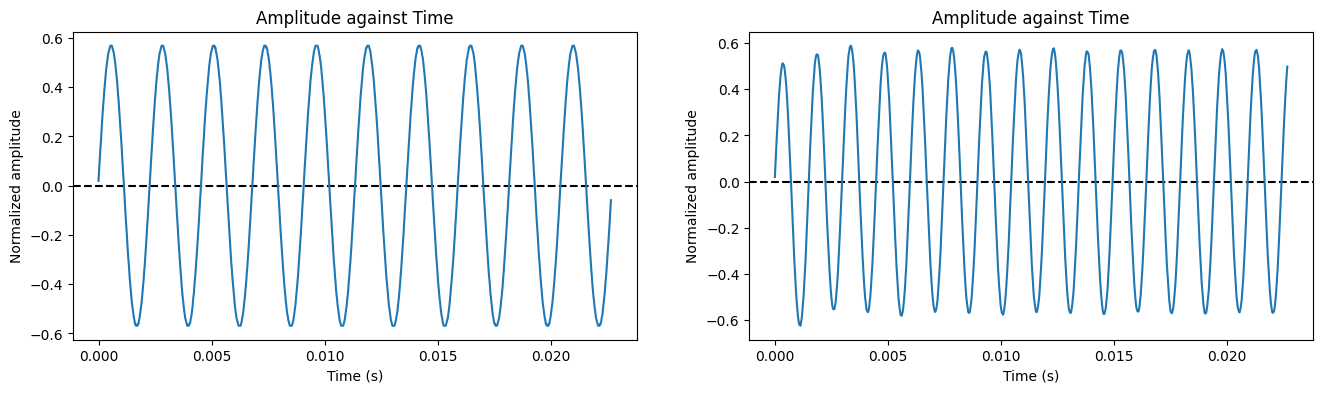

In [6]:
output = "demo/8-bit-test.wav"
shift("samples/8-bit.wav", output, 200)
display.Audio(output)

C:\Users\lesli\AppData\Local\Temp\ipykernel_40872\1799552128.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(filename)


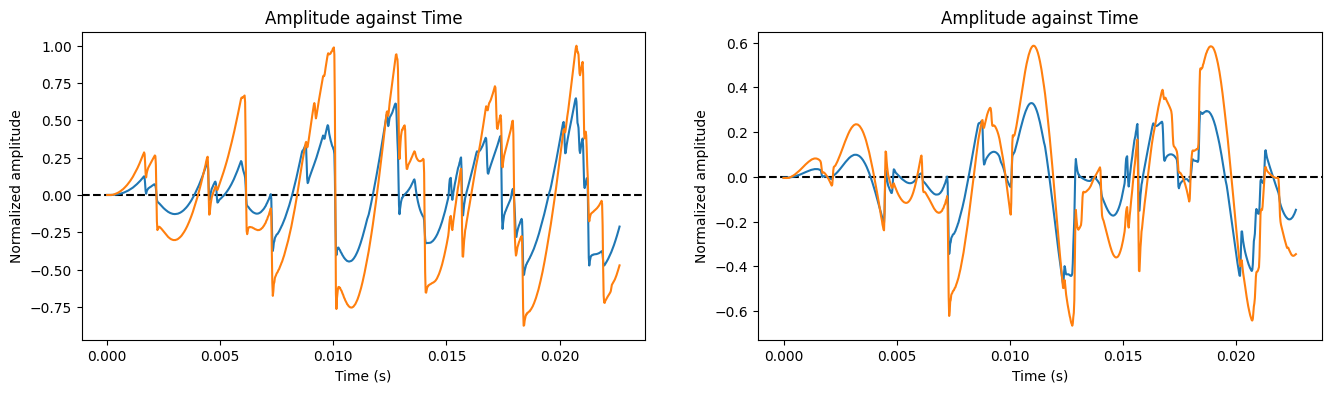

In [7]:
output = "demo/16-bit-test.wav"
shift("samples/16-bit.wav", output, 200, bits_per_sample=16)
display.Audio(output)

## Testing correctness

This section is for verifying the outputs of `FourierTransformer::fft` and `FourierTransformer::ifft`.

In [8]:
pd.options.display.float_format = '{:.5f}'.format

In [9]:
sample_rate, data = wavfile.read("samples/8-bit.wav")
input = np.zeros(1 << 16)
input[:len(data)] = data / 255 * 2 - 1
output = fft(input)

In [10]:
df = pd.DataFrame({
    "input": input,
    "output(real)": [i.real for i in output],
    "output(imaginary)": [i.imag for i in output],
})
df

,input,output(real),output(imaginary)
0,0.01961,0.52549,-0.00000
1,0.05882,4.57282,5.11435
2,0.09020,8.37026,3.57262
3,0.12941,8.70724,2.10144
4,0.16078,8.64626,1.64929
...,...,...,...
65531,0.00000,8.85747,-1.44298
65532,0.00000,8.64626,-1.64929
65533,0.00000,8.70724,-2.10144
65534,0.00000,8.37026,-3.57262


In [11]:
test_df = pd.read_csv("demo/fft.csv")
test_df

,input,fft(real),fft(imaginary),ifft(real),ifft(imaginary)
0,0.01961,0.52549,-0.00000,0.01961,-0.00000
1,0.05882,4.57282,5.11435,0.05882,-0.00000
2,0.09020,8.37026,3.57262,0.09020,-0.00000
3,0.12941,8.70724,2.10144,0.12941,-0.00000
4,0.16078,8.64626,1.64929,0.16078,-0.00000
...,...,...,...,...,...
65531,0.00000,8.85747,-1.44298,-0.00000,-0.00000
65532,0.00000,8.64626,-1.64929,-0.00000,-0.00000
65533,0.00000,8.70724,-2.10144,-0.00000,-0.00000
65534,0.00000,8.37026,-3.57262,-0.00000,-0.00000
